In [13]:
import os
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import re
import numpy.ma as ma

from hbmep.config import Config
from hbmep.model.utils import Site as site

from models import NonHierarchicalBayesianModel
from constants import (
    DATA_PATH,
    TOML_PATH
)

from sklearn.decomposition import PCA


In [14]:
src = "/home/andres/repos/rat-mapping-paper/notebooks/J_RCML_000/selectivity_means.pkl"
with open(src, "rb") as f:
    cath_mid_list, cath_lat_list, mid_mid_list, lat_lat_list, mid_lat_list = pickle.load(f)

In [15]:
src = f"/home/andres/repos/rat-mapping-paper/reports/non-hierarchical/J_RCML_000/non_hierarchical_bayesian_model/inference.pkl"
with open(src, "rb") as f:
    (
        df,
        encoder_dict,
        model,
        posterior_samples,
    ) = pickle.load(f)
    

In [16]:
posterior_samples.keys()

dict_keys(['H', 'H_scale', 'L', 'L_scale', 'a', 'a_loc', 'a_scale', 'b', 'b_scale', 'c_1_scale', 'c_2_scale', 'c₁', 'c₂', 'ell_scale', 'ℓ'])

In [17]:
named_params = [site.a, site.b, site.L, site.ell, site.H]
params = [posterior_samples[param][ ...] for param in named_params]

a = params[0]


In [18]:
positions = encoder_dict[model.features[1]].inverse_transform(df.compound_position.unique())


In [19]:
cath_mid = [(i, cpos) for i, cpos in enumerate(positions) if cpos.split("-")[1][-1] == "M" and cpos.split("-")[0] == ""]
cath_lat = [(i, cpos) for i, cpos in enumerate(positions) if cpos.split("-")[1][-1] == "L" and cpos.split("-")[0] == ""]

mid_mid = [(i, cpos) for i, cpos in enumerate(positions) if cpos.split("-")[1][-1] == "M" and cpos.split("-")[0] != "" and cpos.split("-")[0][-1] == "M"]
lat_lat = [(i, cpos) for i, cpos in enumerate(positions) if cpos.split("-")[1][-1] == "L" and cpos.split("-")[0] != "" and cpos.split("-")[0][-1] == "L"]
mid_lat = [(i, cpos) for i, cpos in enumerate(positions) if cpos.split("-")[1][-1] == "L" and cpos.split("-")[0] != "" and cpos.split("-")[0][-1] == "M"]

cath_mid = [i for (i, cpos) in cath_mid]
cath_lat = [i for (i, cpos) in cath_lat]
mid_mid = [i for (i, cpos) in mid_mid]
lat_lat = [i for (i, cpos) in lat_lat]
mid_lat = [i for (i, cpos) in mid_lat]

In [20]:
a = a/np.nanmedian(a, axis = (0,2,3), keepdims=True)

In [21]:
a.shape

(4000, 8, 21, 6)

In [22]:
a_cath_mid = a[:,:, cath_mid, :]
a_cath_lat = a[:,:, cath_lat, :]
a_mid_mid = a[:,:, mid_mid, :]
a_lat_lat = a[:,:, lat_lat, :]
a_mid_lat = a[:,:, mid_lat, :]

In [23]:
a_cath_mid.shape

(4000, 8, 4, 6)

In [24]:
a_cath_mid = np.nanmean(a_cath_mid, axis = (0,2,3))
a_cath_lat = np.nanmean(a_cath_lat, axis = (0,2,3))
a_mid_mid = np.nanmean(a_mid_mid, axis = (0,2,3))
a_lat_lat = np.nanmean(a_lat_lat, axis = (0,2,3))
a_mid_lat = np.nanmean(a_mid_lat, axis = (0,2,3))

In [25]:
a_cath_mid

array([1.02344862, 0.95084921, 0.84326228, 3.02167879, 1.09076514,
       1.76739452, 1.23398926, 1.47748783])

In [26]:
a_cath_mid_mean = np.nanmean(a_cath_mid, axis = (0))
a_cath_lat_mean = np.nanmean(a_cath_lat, axis = (0))
a_mid_mid_mean = np.nanmean(a_mid_mid, axis = (0))
a_lat_lat_mean = np.nanmean(a_lat_lat, axis = (0))
a_mid_lat_mean = np.nanmean(a_mid_lat, axis = (0))

In [27]:
mean_list = np.array([a_cath_mid_mean, a_cath_lat_mean, a_mid_mid_mean, a_lat_lat_mean, a_mid_lat_mean])


In [28]:
compile_list = np.concatenate((cath_mid_list, cath_lat_list, mid_mid_list, lat_lat_list, mid_lat_list), axis = 1)

In [29]:
compile_list = compile_list/np.nanmedian(compile_list, axis = -1, keepdims = True)

In [30]:
cath_lat_list.shape

(8, 4)

In [31]:
cath_mid_list = compile_list[:, :4]
cath_lat_list = compile_list[:, 4:8]
mid_mid_list = compile_list[:, 8:11]
lat_lat_list = compile_list[:, 11:14]
mid_lat_list = compile_list[:, 14:]

In [32]:
sem_eff = []
sem_sel = []

In [33]:
sem_cm = np.std(np.nanmean(cath_mid_list, axis = (1)))/np.sqrt(len(cath_mid_list))
sem_cl = np.std(np.nanmean(cath_lat_list, axis = (1)))/np.sqrt(len(cath_lat_list))
sem_mm = np.std(np.nanmean(mid_mid_list, axis = (1)))/np.sqrt(len(mid_mid_list))
sem_ll = np.std(np.nanmean(lat_lat_list, axis = (1)))/np.sqrt(len(lat_lat_list))
sem_ml = np.std(np.nanmean(mid_lat_list, axis = (1)))/np.sqrt(len(mid_lat_list))

In [34]:
sem_sel = [sem_cm, sem_cl, sem_mm, sem_ll, sem_ml]

In [35]:
a_cath_mid.shape

(8,)

In [36]:
sem_cm_eff = np.std(a_cath_mid)/np.sqrt(len(a_cath_mid))
sem_cl_eff = np.std(a_cath_lat)/np.sqrt(len(a_cath_lat))
sem_mm_eff = np.std(a_mid_mid)/np.sqrt(len(a_mid_mid))
sem_ll_eff = np.std(a_lat_lat)/np.sqrt(len(a_lat_lat))
sem_ml_eff = np.std(a_mid_lat)/np.sqrt(len(a_mid_lat))

sem_eff = [sem_cm_eff, sem_cl_eff, sem_mm_eff, sem_ll_eff, sem_ml_eff]

In [37]:
compile_list = np.concatenate((cath_mid_list, cath_lat_list, mid_mid_list, lat_lat_list, mid_lat_list), axis = 1)

In [38]:
compile_list.shape

(8, 21)

In [39]:
avg_sel_cath_mid = np.nanmean(cath_mid_list, axis = (0,1))
avg_sel_cath_lat = np.nanmean(cath_lat_list, axis = (0,1))
avg_sel_mid_mid = np.nanmean(mid_mid_list, axis = (0,1))
avg_sel_lat_lat = np.nanmean(lat_lat_list, axis = (0,1))
avg_sel_mid_lat = np.nanmean(mid_lat_list, axis = (0,1))
avg_sel = np.array([avg_sel_cath_mid, avg_sel_cath_lat, avg_sel_mid_mid, avg_sel_lat_lat, avg_sel_mid_lat])

In [40]:
colors = ['red', 'blue', 'green', 'purple', 'orange']


In [41]:
mean_list = np.array([a_cath_mid_mean, a_cath_lat_mean, a_mid_mid_mean, a_lat_lat_mean, a_mid_lat_mean])


In [56]:
mean_list

array([1.42610946, 1.20959176, 1.28194778, 1.10877828, 1.47778817])

In [67]:
mean_list[:2]

array([1.42610946, 1.20959176])

In [42]:
labels = ["Cathode - Mid", "Cathode - Lat", "Mid - Mid", "Lat - Lat", "Mid - Lat"]

Text(0.5, 0, 'Normalized Efficacy')

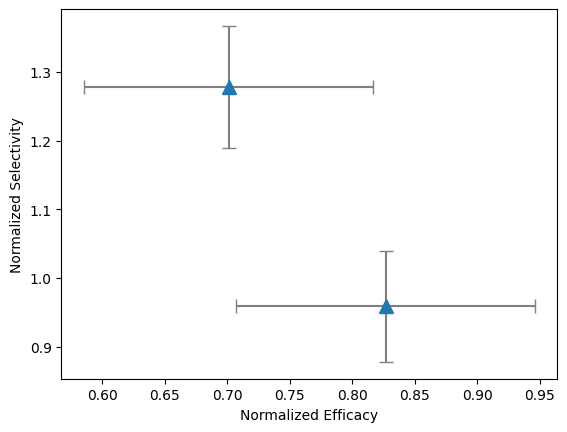

In [68]:
plt.errorbar(x = 1/mean_list[:2], y = avg_sel[:2], xerr = (sem_eff[:2]/mean_list[:2]**2), yerr= sem_sel[:2],fmt='^', capsize=5,ms = 10, ecolor='gray')
plt.ylabel("Normalized Selectivity")
plt.xlabel("Normalized Efficacy")

# for i, txt in enumerate(labels):
#     print(i, txt)
#     plt.annotate(txt, (1/(mean_list[i]), avg_sel[i]))

In [63]:
avg_sel[0]

1.2778635917314578